In [122]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from starsml import compute_permutation_importance

# keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


2023-07-22 11:18:22.557473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
df_good1 = pd.read_csv('data/likely_matches_plane.csv')
df_good = df_good1.query("prob >= 0.95 and separation <= 0.2")

df_bad = pd.read_csv('data/unlikely_matches_plane.csv')

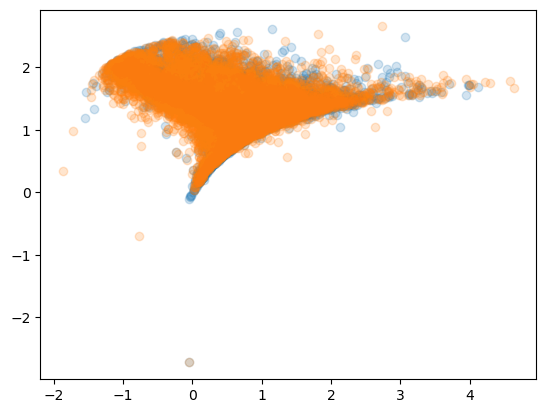

In [15]:
plt.scatter(df_good['bp_g'],df_good['g_rp'],alpha=0.2,)
plt.scatter(df_bad['bp_g'],df_bad['g_rp'],alpha=0.2)


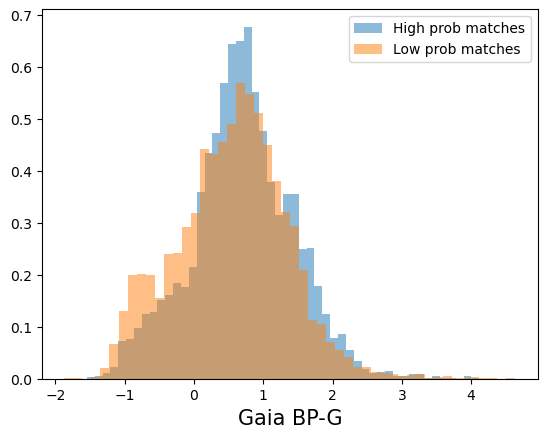

In [16]:
plt.hist(df_good['bp_g'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_g'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-G',size=15)
plt.legend()
plt.savefig('figures/Gaia_BP_G.pdf',dpi=300)

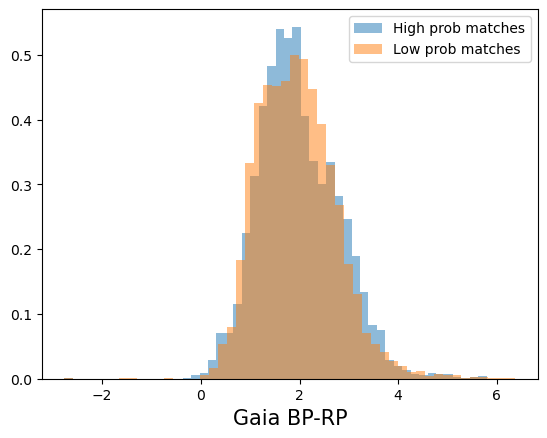

In [17]:
plt.hist(df_good['bp_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-RP',size=15)
plt.legend()
plt.savefig('figures/Gaia_BP_RP.pdf',dpi=300)

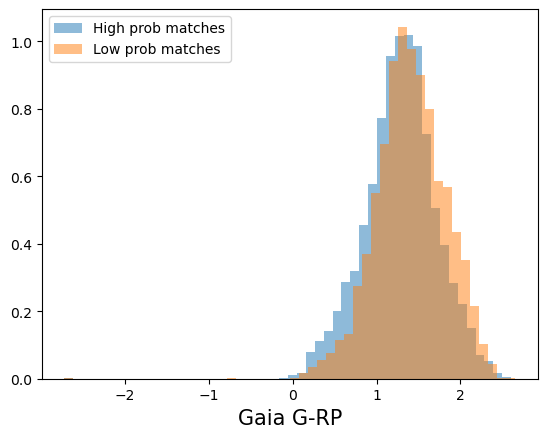

In [18]:
plt.hist(df_good['g_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['g_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G-RP',size=15)
plt.legend()
plt.savefig('figures/Gaia_G_RP.pdf',dpi=300)

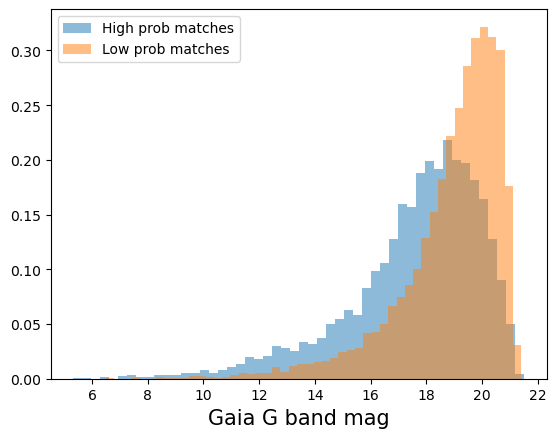

In [19]:
plt.hist(df_good['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G band mag',size=15)
#plt.xscale('log')
plt.legend()
plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

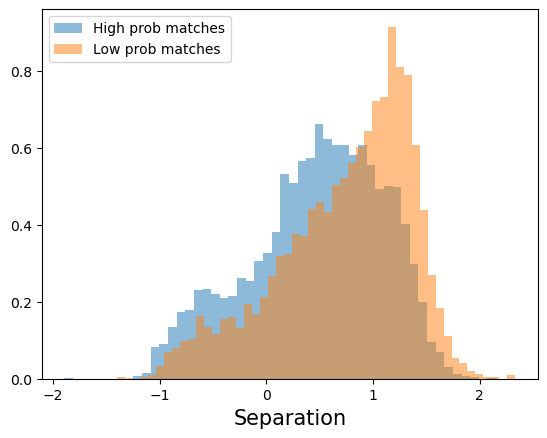

In [20]:
plt.hist(np.log10(100./df_good['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(100./df_bad['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Separation',size=15)
#plt.xscale('log')
plt.legend()
plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

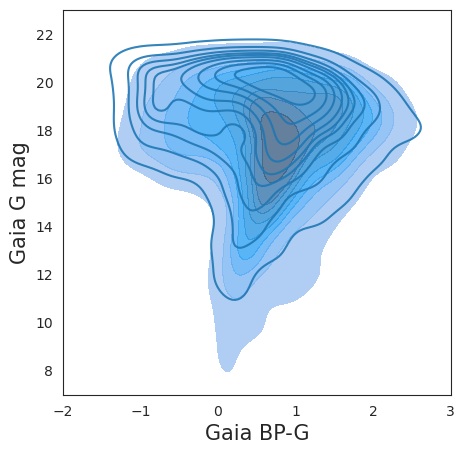

In [22]:
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
sns.kdeplot(x=df_good.bp_g, y=df_good.phot_g_mean_mag, label = 'High prob matches',fill=True,alpha=0.8)
sns.kdeplot(x=df_bad.bp_g, y=df_bad.phot_g_mean_mag, label = 'Low prob matches',fill=False,alpha=0.9)
plt.xlim(-2,3)
plt.ylim(7,23)
plt.xlabel('Gaia BP-G',size=15)
plt.ylabel('Gaia G mag',size=15)
plt.savefig('figures/contour.pdf',dpi=300)

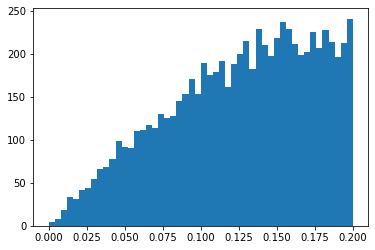

In [7]:
plt.hist(df_good['separation'],bins=50)
plt.show()

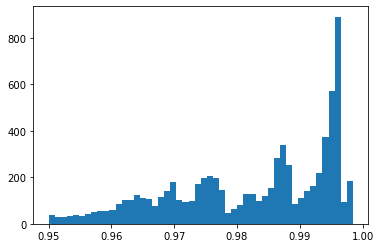

In [8]:
plt.hist(df_good['prob'],bins=50)
plt.show()

In [107]:

feature_names = [
    'separation', 
    'phot_g_mean_flux', 
    'phot_g_mean_flux_error', 
    'phot_g_mean_flux_over_error', 
    'phot_bp_mean_flux', 
    'phot_bp_mean_flux_error', 
    'phot_bp_mean_flux_over_error', 
    'phot_rp_mean_flux', 
    'phot_rp_mean_flux_error', 
    'phot_rp_mean_flux_over_error', 
    'bp_rp', 
    'bp_g', 
    'g_rp'
]

In [30]:
X1 = np.array([df_good['separation'].values, np.log10(df_good['phot_g_mean_flux'].values), np.log10(df_good['phot_g_mean_flux_error'].values), 
      np.log10(df_good['phot_g_mean_flux_over_error'].values), np.log10(df_good['phot_bp_mean_flux'].values), 
      np.log10(df_good['phot_bp_mean_flux_error'].values), np.log10(df_good['phot_bp_mean_flux_over_error'].values), 
      np.log10(df_good['phot_rp_mean_flux'].values), np.log10(df_good['phot_rp_mean_flux_error'].values), 
      np.log10(df_good['phot_rp_mean_flux_over_error'].values), np.log10(df_good['bp_rp'].values),
      np.log10(df_good['bp_g'].values), np.log10(df_good['g_rp'].values)])
#X1 = np.array([np.log10(df_good['phot_g_mean_flux'].values), np.log10(df_good['phot_g_mean_flux_error'].values), 
#      np.log10(df_good['phot_g_mean_flux_over_error'].values)])

/tmp/ipykernel_32472/496415149.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(df_good['phot_rp_mean_flux_over_error'].values), np.log10(df_good['bp_rp'].values),
/tmp/ipykernel_32472/496415149.py:6: RuntimeWarning: invalid value encountered in log10
  np.log10(df_good['bp_g'].values), np.log10(df_good['g_rp'].values)])


In [31]:
X1_train = X1.T[0:5400]

In [32]:
shape(X1_train)

(5400, 13)

In [33]:
X1_test = X1.T[5400:] 

In [34]:
X2 = np.array([df_bad['separation'].values, np.log10(df_bad['phot_g_mean_flux'].values), np.log10(df_bad['phot_g_mean_flux_error'].values), 
      np.log10(df_bad['phot_g_mean_flux_over_error'].values), np.log10(df_bad['phot_bp_mean_flux'].values), 
      np.log10(df_bad['phot_bp_mean_flux_error'].values), np.log10(df_bad['phot_bp_mean_flux_over_error'].values), 
      np.log10(df_bad['phot_rp_mean_flux'].values), np.log10(df_bad['phot_rp_mean_flux_error'].values), 
      np.log10(df_bad['phot_rp_mean_flux_over_error'].values), np.log10(df_bad['bp_rp'].values),
      np.log10(df_bad['bp_g'].values), np.log10(df_bad['g_rp'].values)])
#X2 = np.array([np.log10(df_bad['phot_g_mean_flux'].values), np.log10(df_bad['phot_g_mean_flux_error'].values), 
#      np.log10(df_bad['phot_g_mean_flux_over_error'].values)])

/tmp/ipykernel_32472/4012784119.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(df_bad['phot_rp_mean_flux_over_error'].values), np.log10(df_bad['bp_rp'].values),
/tmp/ipykernel_32472/4012784119.py:6: RuntimeWarning: invalid value encountered in log10
  np.log10(df_bad['bp_g'].values), np.log10(df_bad['g_rp'].values)])


In [57]:
X2.shape

(13, 12974)

In [35]:
X2_train = X2.T[0:10000]

In [36]:
X2_test = X2.T[10000:]

In [41]:
shape(X2_test)

(2974, 13)

In [39]:
X_train = np.concatenate((X1_train,X2_train), axis=0)

In [40]:
X_test = np.concatenate((X1_test,X2_test), axis=0)

In [42]:
Y1_train = np.ones(5400)

In [43]:
Y1_test = np.ones(1928)

In [44]:
Y2_train = np.zeros(10000)

In [45]:
Y2_test = np.zeros(2974)

In [46]:
Y_train = np.concatenate((Y1_train,Y2_train), axis=0)

In [47]:
Y_test = np.concatenate((Y1_test,Y2_test), axis=0)

In [48]:
print(shape(X_train),shape(Y_train))

(15400, 13) (15400,)


In [50]:
arr = np.arange(15400)
np.random.shuffle(arr)
arr

array([ 7813,  2463,  5384, ...,  6271, 14277, 12796])

In [51]:
X_train = X_train[arr]

In [52]:
Y_train = Y_train[arr]

In [ ]:
num_samples = X_train.shape[0]
nan_count_per_feature = np.isnan(X_train).sum(axis=0)

# Calculate the percentage for each feature
nan_percentage_per_feature = (nan_count_per_feature / num_samples) * 100

for i, percentage in enumerate(nan_percentage_per_feature):
    print(f"Percentage of NaN values in feature {feature_names[i]}: {percentage:.2f}%")


In [58]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)

In [59]:
print(shape(X_test),shape(Y_test))

(4902, 13) (4902,)


In [60]:
arr = np.arange(4902)
np.random.shuffle(arr)
arr

array([2687, 4597, 4901, ..., 3787, 1355, 4333])

In [61]:
X_test = X_test[arr]

In [62]:
Y_test = Y_test[arr]

In [63]:
imp_mean.fit(X_test)
X_test = imp_mean.transform(X_test)

#### Baseline Models

In [126]:
# Model Building
clf = LogisticRegression(max_iter=10000)  # max_iter may need to be increased depending on data convergence
clf.fit(X_train, Y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_prob))

#feature_importances = clf.coef_[0]
#for i, imp in enumerate(feature_importances):
#    print(f"{feature_names[i]}: Coefficient = {imp:.4f}")

Accuracy: 0.7715218278253774
Precision: 0.7007952286282306
Recall: 0.7313278008298755
F1 Score: 0.7157360406091371
AUC-ROC: 0.8595502306294943


In [127]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

Accuracy: 0.7307221542227662
Precision: 0.6205392545598731
Recall: 0.8117219917012448
F1 Score: 0.7033707865168539
AUC-ROC: 0.8228914946130642


In [136]:
# Model Building
clf_svm = SVC(kernel='linear', probability=True, random_state=42)  # Using 'linear' kernel as a baseline. Probability is True for AUC-ROC.
clf_svm.fit(X_train, Y_train)

# Predictions
y_pred_svm = clf_svm.predict(X_test)
y_pred_svm_prob = clf_svm.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_svm))
print("Precision:", precision_score(Y_test, y_pred_svm))
print("Recall:", recall_score(Y_test, y_pred_svm))
print("F1 Score:", f1_score(Y_test, y_pred_svm))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_svm_prob))

Accuracy: 0.7807017543859649
Precision: 0.6918578497525866
Recall: 0.7977178423236515
F1 Score: 0.7410262587328356
AUC-ROC: 0.8625143707428419


#### NN

In [64]:
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(13,)))
network.add(layers.Dense(64, activation='relu', input_shape=(128,)))
network.add(layers.Dense(1, activation='sigmoid'))

2023-07-22 19:00:23.936053: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [66]:
Adagrad = optimizers.Adagrad(learning_rate=0.005)
network.compile(optimizer=Adagrad,
                loss='binary_crossentropy',
                metrics=['binary_accuracy'])
#optimizer.lr.set_value(0.02)

In [67]:
history = network.fit(X_train, Y_train, validation_split=0.2, epochs=200, batch_size=256)

Epoch 1/200
49/49 [==============================] - 2s 23ms/step - loss: 0.6498 - binary_accuracy: 0.6459 - val_loss: 0.6299 - val_binary_accuracy: 0.6724
Epoch 2/200
49/49 [==============================] - 1s 13ms/step - loss: 0.6267 - binary_accuracy: 0.6547 - val_loss: 0.6085 - val_binary_accuracy: 0.6649
Epoch 3/200
49/49 [==============================] - 1s 13ms/step - loss: 0.6119 - binary_accuracy: 0.6666 - val_loss: 0.5937 - val_binary_accuracy: 0.6844
Epoch 4/200
49/49 [==============================] - 1s 13ms/step - loss: 0.6006 - binary_accuracy: 0.6774 - val_loss: 0.5837 - val_binary_accuracy: 0.7107
Epoch 5/200
49/49 [==============================] - 1s 15ms/step - loss: 0.5902 - binary_accuracy: 0.6920 - val_loss: 0.5730 - val_binary_accuracy: 0.7136
Epoch 6/200
49/49 [==============================] - 1s 24ms/step - loss: 0.5807 - binary_accuracy: 0.6997 - val_loss: 0.5660 - val_binary_accuracy: 0.7308
Epoch 7/200
49/49 [==============================] - 1s 16ms/ste

In [69]:
network.save('models/model0.h5')

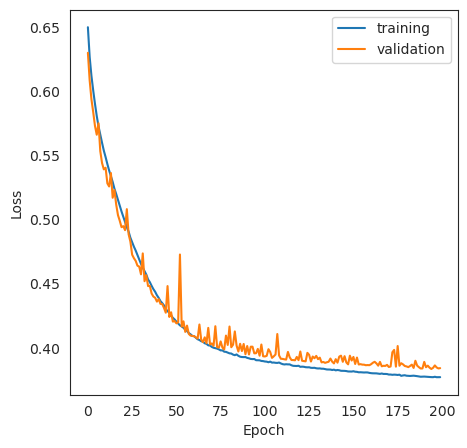

In [70]:
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('models/loss_nn0.pdf')

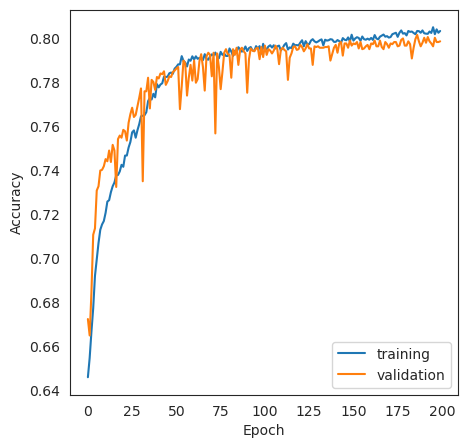

In [71]:
plt.plot(history.history['binary_accuracy'],label='training')
plt.plot(history.history['val_binary_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/acc_nn.pdf')

In [72]:
print('\n# Evaluate on test data')
results = network.evaluate(X_test, Y_test, batch_size=256)
print('test loss, test acc:', results)


# Evaluate on test data
20/20 [==============================] - 0s 8ms/step - loss: 0.4212 - binary_accuracy: 0.7817
test loss, test acc: [0.4212074279785156, 0.7817217707633972]


In [104]:
# Predict probabilities for the test set
y_pred_probs = network.predict(X_test).ravel()

# Convert probabilities to class labels (0 or 1) using a threshold, typically 0.5 for binary classification
y_pred_label = (y_pred_probs > 0.5).astype(int)

# Compute precision, recall, and F1 score
precision = precision_score(Y_test, y_pred_label)
recall = recall_score(Y_test, y_pred_label)
f1 = f1_score(Y_test, y_pred_label)

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Display metrics
print('\n# Extended Evaluation Metrics')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC:', roc_auc)


154/154 [==============================] - 1s 7ms/step

# Extended Evaluation Metrics
Precision: 0.702167766258247
Recall: 0.7728215767634855
F1 Score: 0.7358024691358025
AUC: 0.8672415428875985


In [106]:
# Compute permutation importance
importances = compute_permutation_importance(network, X_test, Y_test)

# Display the importances
for i, imp in enumerate(importances):
    print(f"{feature_names[i]}: Importance = {imp:.4f}")

154/154 [==============================] - 1s 5ms/step
separation: Importance = 0.1946
phot_g_mean_flux: Importance = 0.1059
phot_g_mean_flux_error: Importance = -0.0018
phot_g_mean_flux_over_error: Importance = 0.0045
phot_bp_mean_flux: Importance = 0.1028
phot_bp_mean_flux_error: Importance = 0.0080
phot_bp_mean_flux_over_error: Importance = -0.0139
phot_rp_mean_flux: Importance = -0.0063
phot_rp_mean_flux_error: Importance = 0.0082
phot_rp_mean_flux_over_error: Importance = -0.0059
bp_rp: Importance = 0.0014
bp_g: Importance = -0.0063
g_rp: Importance = 0.0143
